# Multi Greek Hedging

In [200]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np

from utils.process import process_options,process_underlying,process_rf
from utils.greeks import delta, gamma, vega, theta, rho
from utils.implied_volatility import implied_vol_b76
from tqdm import tqdm

tqdm.pandas()


In [201]:
option_data = pd.read_csv("../data/SPYOPT_processed.csv",parse_dates=True)
underlying = pd.read_csv("../data/SPYFUT_processed.csv",parse_dates=True).rename(columns={'close': 'futures_close'})
rf_rate = pd.read_csv("../data/RFRate.csv", parse_dates=True).rename(columns={'rate': 'rf_rate'})

In [202]:
all_data = pd.merge(option_data, 
                    underlying[['ts_event', 'expiration_date', 'futures_close']], 
                    on=['ts_event', 'expiration_date'], 
                    how='left')

all_data = pd.merge(all_data, 
                    rf_rate[['ts_event', 'rf_rate']], 
                    on='ts_event', 
                    how='left')

all_data['rf_rate'] = all_data['rf_rate'].ffill().bfill()
all_data['rf_rate'] = 12 *np.log(1 + all_data['rf_rate']/1200)

all_data['ts_event'] = pd.to_datetime(all_data['ts_event'])
all_data['expiration_date'] = pd.to_datetime(all_data['expiration_date'])

all_data = all_data.set_index('ts_event')

all_data['futures_close'] = all_data['futures_close'].ffill()

all_data = all_data.reset_index()

all_data = all_data.drop(columns=['open', 'high', 'low', 'volume'])

all_data = all_data.rename(columns={'close': 'Value','futures_close': 'S','rf_rate': 'r','strike': 'K'})


all_data['T'] = (all_data['expiration_date'] - all_data['ts_event']).dt.days / 365.0

# Preparing Data

Since we are going to just be dealing with calls, we can filter out all the puts that are being traded.

In [ ]:
#Reindexing
def grouper1(group):
    start_date = group['ts_event'].min()
    end_date = group['ts_event'].max()
    group = group.set_index('ts_event').reindex(pd.date_range(start=start_date, end=end_date, freq='D')).reset_index()
    group['option_type'] = group['option_type'].ffill()
    group['K'] = group['K'].ffill()
    group['expiration_date'] = group['expiration_date'].ffill()
    return group

def filter1(group):
    if len(group) < 10:
        return False
    
    S0    = group['S'].iloc[0]                      # spot
    K     = group['K'].iloc[0]
    T    = group['T'].iloc[0]                      # time to maturity
    r = group['r'].iloc[0]                      # risk-free rate
    upper = S0 *np.exp(r*T + 1*0.2*np.sqrt(T))  # upper bound
    lower = S0 *np.exp(r*T - 1mn *0.2*np.sqrt(T))  # lower bound
    return (upper >= K >= lower)
    

all_data = all_data.groupby(['expiration_date','K','option_type']).filter(filter1).groupby(['expiration_date','K','option_type']).progress_apply(grouper1)

 99%|█████████▊| 7997/8105 [00:05<00:00, 1639.64it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 8105/8105 [00:05<00:00, 1354.76it/s]


To accurately do the Greek hedging, you need to have the values for all greeks for each outstanding option at each time point.

Basically we need a big Tensor of shape  $ G \in\mathbb{R}^{n\times m\times d}$ with $n$ = timesteps (trading days), $m$ = outstanding options (strike prices and expiration dates), $d$ the greeks (delta,gamma,vega,theta,rho)

#### Small Cells

In [204]:
all_data = all_data.reset_index(drop=True).rename(columns={'index': 'ts_event'})

In [205]:
all_data['r'] = all_data['r'].ffill()
all_data['T'] = (all_data['expiration_date'] - all_data['ts_event']).dt.days / 365.0

In [206]:
underlying['ts_event'] = pd.to_datetime(underlying['ts_event'])
underlying['expiration_date'] = pd.to_datetime(underlying['expiration_date'])

In [207]:
all_data = pd.merge(all_data, 
                    underlying[['ts_event', 'expiration_date', 'futures_close']], 
                    on=['ts_event', 'expiration_date'], 
                    how='left')
all_data['S'] = all_data['S'].fillna(all_data['futures_close'])
all_data = all_data.drop(columns=['futures_close'])


In [208]:
all_data = all_data[ all_data['ts_event'].dt.dayofweek < 5 ]

In [209]:
def grouper2(group):
    group['S'] = group['S'].interpolate(method='spline', order=1)
    group['Value'] = group['Value'].interpolate(method='spline', order=1)
    return group

all_data = all_data.groupby(['expiration_date', 'K', 'option_type']).progress_apply(grouper2).reset_index(drop=True)


 24%|██▎       | 1922/8105 [00:04<00:09, 630.02it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/pandas/core/missing.py:604: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  terp = interpolate.UnivariateSpline(x, y, k=order, **kwargs)
 99%|█████████▉| 8049/8105 [00:18<00:00, 461.41it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns afte

#### Splitting to Calls

In [210]:
calls_data = all_data[all_data['option_type'] == 'C']

In [211]:
calls_data['IV'] = calls_data.progress_apply(lambda row: implied_vol_b76(row['S'], row['K'], row['T'], row['r'], row['Value'], row['option_type']), axis=1)

  0%|          | 181/577673 [00:00<22:42, 423.86it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/implied_volatility.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
100%|██████████| 577673/577673 [05:30<00:00, 1749.48it/s]
/var/folders/7k/ytnljb093xg6bbfksvnhyg940000gn/T/ipykernel_55869/2625644187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls_data['IV'] = calls_data.progress_apply(lambda row: implied_vol_b76(row['S'], row['K'], row['T'], row['r'], row['Value'], row['option_type']), axis=1)


In [212]:
def grouper3(group):
    vol_surface = group.pivot(index='K', columns='T', values='IV')
    vol_surface = vol_surface.sort_index().sort_index(axis=1)

    # Interpolate along strikes and maturities
    vol_surface = vol_surface.interpolate(axis=0, method='linear')
    vol_surface = vol_surface.interpolate(axis=1, method='linear')

    # Edge-fill any remaining NaNs
    vol_surface = vol_surface.ffill(axis=0).bfill(axis=0)
    vol_surface = vol_surface.ffill(axis=1).bfill(axis=1)

    filled_df = vol_surface.stack().rename('IV').reset_index()

    # Map interpolated values back into original DataFrame
    iv_map = filled_df.set_index(['K', 'T'])['IV']
    group['IV'] = group.set_index(['K', 'T'])['IV'].fillna(iv_map).values
    return group


In [213]:
calls_data = calls_data.groupby(['ts_event']).progress_apply(grouper3)

 99%|█████████▉| 1838/1859 [00:06<00:00, 280.36it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1859/1859 [00:06<00:00, 294.37it/s]


#### Add Greeks

In [214]:
calls_data['delta'] = calls_data.progress_apply(lambda row: delta(row['S'], row['K'], row['T'], row['r'], row['IV']), axis=1)
calls_data['gamma'] = calls_data.progress_apply(lambda row: gamma(row['S'], row['K'], row['T'], row['r'], row['IV']), axis=1)
calls_data['vega'] = calls_data.progress_apply(lambda row: vega(row['S'], row['K'], row['T'], row['r'], row['IV']), axis=1)


  1%|          | 5975/577673 [00:00<00:44, 12758.67it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  return norm.cdf((np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)))
  1%|          | 5882/577673 [00:00<00:43, 13293.20it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:10: RuntimeWarning: invalid value encountered in scalar divide
  return norm.pdf(
  1%|          | 5917/577673 [00:00<00:43, 13228.78it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/notebooks/../utils/greeks.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  * norm.pdf((np.log(S / K) + (r + 0.5 * sigma**2) * T

In [215]:
calls_data = calls_data.reset_index(drop=True)
calls_data = calls_data[calls_data['T'] != 0]


In [260]:
import pandas as pd 
from pandas.tseries.offsets import DateOffset


def grouper4(group):
    pivot = (
        group
        .set_index(['expiration_date', 'K'])[['delta','gamma','vega']]   # index by the two “option” keys, keep only the Greeks
        .T                                                               # transpose so that the Greeks become the rows
        )
    
    values = pivot.values
    weights = pd.Series(data = np.linalg.pinv(values) @ np.array([-1, 0, 0]).T, index=pivot.columns)

    return weights
        
def grouper4half(group):
    pivot = (
        group
        .set_index(['expiration_date', 'K'])[['delta','gamma','vega']]   # index by the two “option” keys, keep only the Greeks
        .T                                                               # transpose so that the Greeks become the rows
        )
    
    values = pivot.values
    weights = pd.Series(data = np.linalg.pinv(values) @ np.array([-1, 0, 0]).T, index=pivot.columns)

    return pd.Series(data=values @ weights.values, index=pivot.index)



In [261]:
distribution = calls_data.groupby(['ts_event']).progress_apply(grouper4)

 98%|█████████▊| 1830/1859 [00:01<00:00, 2075.71it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1859/1859 [00:01<00:00, 1365.23it/s]


In [262]:
greeks = calls_data.groupby(['ts_event']).progress_apply(grouper4half)
greeks.to_csv('../results/Greeks.csv')

100%|█████████▉| 1853/1859 [00:00<00:00, 2123.69it/s]/Users/carloteufel/Documents/Projects/risk-neutral-hedging/.venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1859/1859 [00:00<00:00, 2005.25it/s]


In [218]:
distribution_horizontal = distribution.unstack(level=['expiration_date','K'])


In [219]:
distribution_horizontal = distribution_horizontal.fillna(0)
distribution_horizontal = distribution_horizontal.sort_index(axis=1, level=[0,1])

In [220]:
distribution_horizontal.to_csv('../results/HedgingDistribution.csv')

In [221]:
calls_data_horizontal = (
    calls_data
    .pivot_table(
        index='ts_event',
        columns=['expiration_date', 'K'],
        values='Value',
        aggfunc='first'        # or np.mean / sum etc. if duplicates expected
    )
)
calls_data_horizontal = calls_data_horizontal.sort_index(axis=1, level=[0, 1])
calls_data_horizontal = calls_data_horizontal.fillna(0.0)


In [222]:
calls_data_horizontal.to_csv('../results/CallsDataPrices.csv')

In [223]:
def grouper5(group):
    # normalize “today” to midnight
    today = pd.Timestamp.today().normalize()
    # the soonest expiration in the group
    min_date = group['expiration_date'].min()

    # check if the soonest date is < 7 days from now (and still in the future)
    delta = (min_date - today).days
    if 0 <= delta < 7:
        # target = 3 months from today
        target = today + pd.DateOffset(months=3)
        # find index of expiration_date closest to target
        closest_idx = (group['expiration_date'] - target).abs().idxmin()
        closest_date = group.loc[closest_idx, 'expiration_date']
    else:
        closest_date = min_date

    # return all rows matching the chosen expiration_date
    return group[group['expiration_date'] == closest_date]

In [224]:
futures_data = calls_data[['ts_event', 'expiration_date', 'S']].drop_duplicates()
futures_data = futures_data.groupby(['ts_event']).apply(grouper5).reset_index(drop=True).set_index('ts_event')
futures_data = futures_data.sort_index()
futures_data = futures_data.loc[calls_data_horizontal.index]
futures_data = futures_data.groupby('ts_event').mean()


/var/folders/7k/ytnljb093xg6bbfksvnhyg940000gn/T/ipykernel_55869/818927698.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  futures_data = futures_data.groupby(['ts_event']).apply(grouper5).reset_index(drop=True).set_index('ts_event')


In [225]:
futures_data = futures_data.dropna()

In [226]:
futures_data.to_csv('../results/FuturesData.csv')


## Rollout 

In [227]:
import matplotlib.pyplot as plt

In [265]:
option_distributions = pd.read_csv('../results/HedgingDistribution.csv',header=[0,1],    # two header rows → first level = expiration_date, 2nd level = K
    index_col=0, parse_dates=True)  # index by the first column, parse dates

option_prices = pd.read_csv('../results/CallsDataPrices.csv', header=[0,1],    # two header rows → first level = expiration_date, 2nd level = K
    index_col=0, parse_dates=True)  # index by the first column, parse

futures_prices = pd.read_csv('../results/FuturesData.csv', parse_dates=True, index_col='ts_event')

greeks_data = pd.read_csv('../results/Greeks.csv', parse_dates=True, index_col='ts_event')

In [266]:
individual_options_positions = option_distributions.values * option_prices.values
total_options_position = individual_options_positions.sum(axis=1)
future_positions = futures_prices['S'].values
total_positions = total_options_position + future_positions

In [267]:
greeks_data.iloc[0][0]

/var/folders/7k/ytnljb093xg6bbfksvnhyg940000gn/T/ipykernel_55869/2080973019.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  greeks_data.iloc[0][0]


np.float64(-0.9999999999994592)

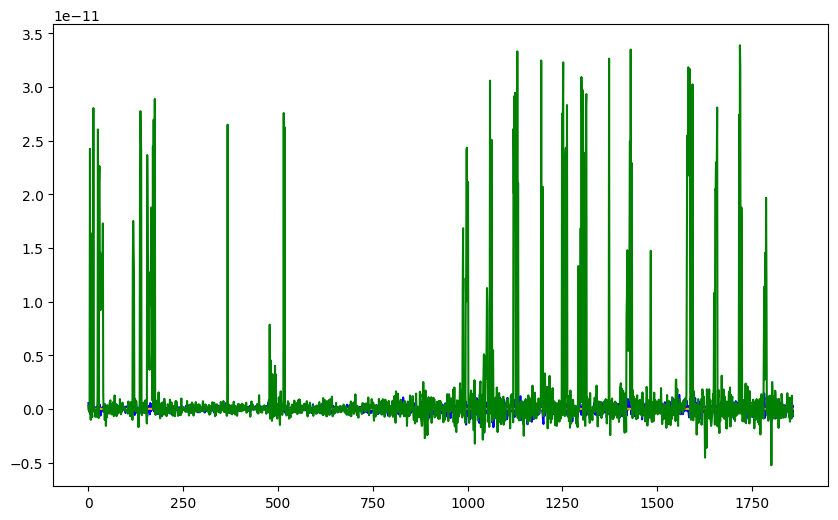

In [275]:
plt.figure(figsize=(10, 6))
plt.plot([value +1 for value in greeks_data.iloc[:,0].values], label='Greeks', color='blue')
plt.plot(greeks_data.iloc[:,1].values, label='Gamma', color='orange')
plt.plot(greeks_data.iloc[:,2].values, label='Vega', color='green')

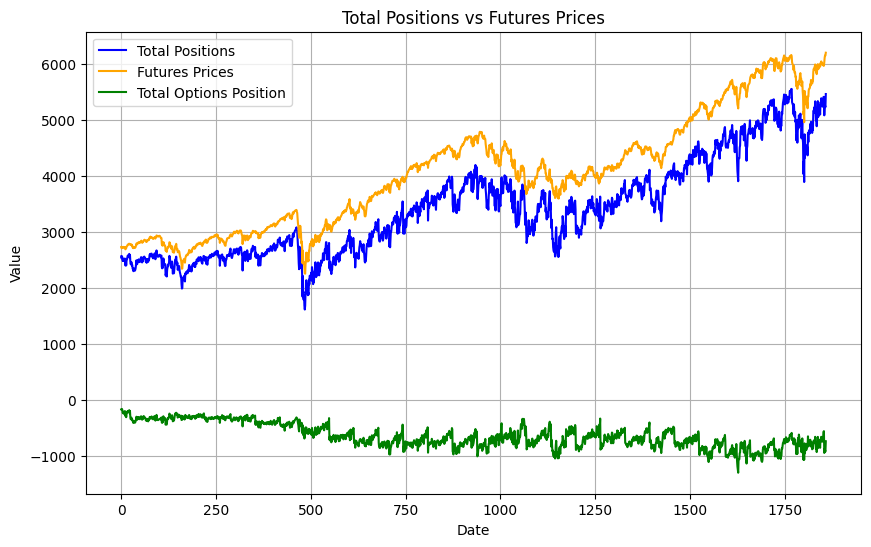

In [232]:
plt.figure(figsize=(10, 6))
plt.plot(total_positions, label='Total Positions', color='blue')
plt.plot(futures_prices['S'].values, label='Futures Prices', color='orange')
plt.plot(total_options_position, label='Total Options Position', color='green')
plt.title('Total Positions vs Futures Prices')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()